In [1]:
import os
import sys

sys.stderr = open(os.devnull, "w")

import warnings
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from functools import partial
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
from sktime.forecasting.tbats import TBATS
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

warnings.filterwarnings('ignore', category=FutureWarning)

/Users/jchan/miniconda3/envs/sales_forecasting/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jchan/miniconda3/envs/sales_forecasting/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jchan/miniconda3/envs/sales_forecasting/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jchan/miniconda3/envs/sales_forecasting/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jchan/miniconda3/envs/sales_forecasting/lib/python3.12/site-packages/

In [2]:
sales = pd.read_csv('pedidos.csv', sep=';')

In [3]:
df = sales[['account_id', 'sales_channel_id']].value_counts()
df = pd.DataFrame(df).reset_index()

In [4]:
LOOKBACK = 3
SEASONAL_PERIODS = (24, 24*7)
COVERAGE = 0.35
END_DATE = pd.to_datetime(pd.to_datetime(sales['created_date'].max()).strftime("%Y-%m-%d %H:00:00"))
START_DATE = END_DATE - timedelta(hours=END_DATE.hour)
TEST_SIZE = int((END_DATE - START_DATE).seconds / 60**2 + 1)

In [5]:
OOT_DATE = START_DATE + timedelta(hours=23)

In [6]:
OOT_PERIODS = int((OOT_DATE - END_DATE).seconds / 60**2 + 1)

In [7]:
oot_dates = pd.DatetimeIndex([END_DATE+timedelta(hours=h) for h in range(1, OOT_PERIODS)], freq='h')
df_oot = pd.DataFrame(index=oot_dates)

account_id: f9129295-bb08-4330-b60c-9f0beadda521
sales_channel_id: 1
price_total_agg
train RMSE: 286238.795
train MAE:  94896.227
test RMSE: 51325.116
test MAE:  41768.423


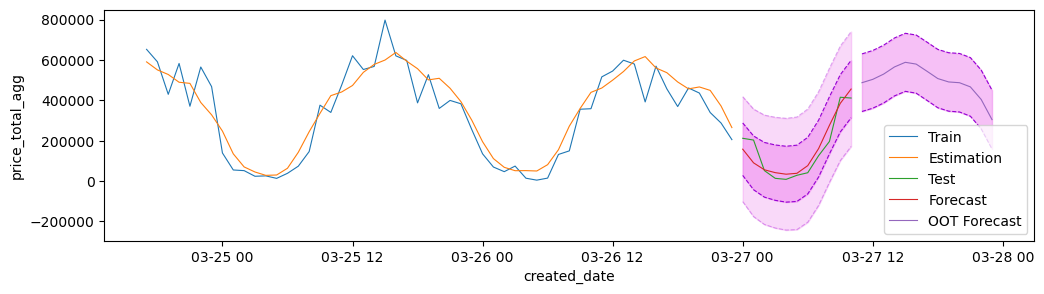

n_orders
train RMSE: 25.676
train MAE:  17.476
test RMSE: 22.919
test MAE:  17.052


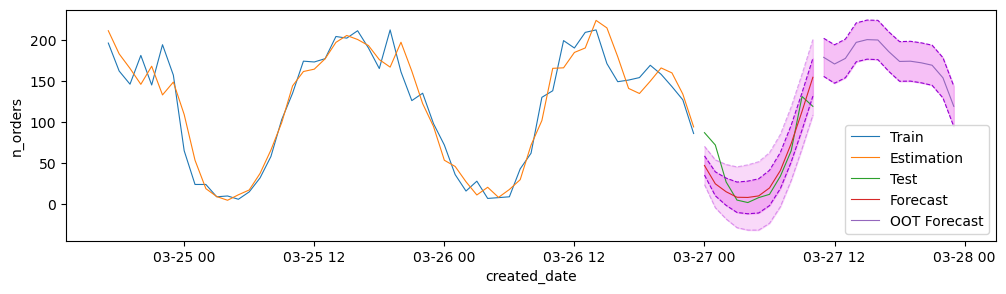

account_id: f9129295-bb08-4330-b60c-9f0beadda521
sales_channel_id: 1
price_total_agg


KeyboardInterrupt: 

In [ ]:
id_pairs = list(zip(df['account_id'], df['sales_channel_id']))
summary_dict = {}
for account_id, sales_channel_id in tqdm(id_pairs):
    print(f'account_id: {account_id}')
    print(f'sales_channel_id: {sales_channel_id}')
    
    summary_dict[(account_id, sales_channel_id)] = {}
    
    cond = (sales['account_id'] == account_id) & (sales['sales_channel_id'] == sales_channel_id)
    df_client = sales[cond].drop(['account_id', 'sales_channel_id'], axis=1)
    df_client['created_date'] = pd.to_datetime(df_client['created_date'], format='%Y-%m-%d %H:%M:%S.%f %z')
    df_client = df_client.sort_values('created_date').reset_index(drop=True)
    df_client['created_date'] = df_client['created_date'].dt.strftime("%Y-%m-%d %H:00:00").reset_index(drop=True)
    
    df_client_mod = df_client.groupby('created_date').agg(price_total_agg=('price_total', 'sum'), n_orders=('created_date', 'count'))
    df_client_mod.index = pd.to_datetime(df_client_mod.index, format='%Y-%m-%d %H:00:00')
    
    end_date = pd.to_datetime(END_DATE, format='%Y-%m-%d %H:%M:%S')
    start_date = end_date - relativedelta(months=LOOKBACK)
    date_index = pd.Series(pd.date_range(start=start_date, end=end_date, freq='h', name='created_date'))
    df_client_mod = pd.merge(date_index, df_client_mod, how='left', on='created_date').set_index('created_date')
    
    forecast_dict = {}
    
    for n, col in enumerate(['price_total_agg', 'n_orders']):
        print(col)
        
        summary_dict[(account_id, sales_channel_id)][f'dataset_{n}'] = {}
        summary_dict[(account_id, sales_channel_id)][f'dataset_{n}']['name'] = col
        
        forecast_dict[f'dataset_{n}'] = {}
        
        df = df_client_mod[col]
        
        df.fillna(0, inplace=True)
        
        df_train = df.iloc[:-TEST_SIZE]
        df_test = df.iloc[-TEST_SIZE:]
        
        model = TBATS(sp=[24, 168], show_warnings=False, n_jobs=-1)
        model.fit(df_train)
        
        forecast = model.predict(fh=df.index)
        forecast_int = model.predict_interval(fh=df.index, coverage=COVERAGE)
        
        forecast_dict[f'dataset_{n}']['forecast'] = forecast[-TEST_SIZE:]
        forecast_dict[f'dataset_{n}']['forecast_lower'] = forecast_int.iloc[-TEST_SIZE:, 0]
        forecast_dict[f'dataset_{n}']['forecast_upper'] = forecast_int.iloc[-TEST_SIZE:, 1]
        
        oot_forecast = model.predict(fh=df_oot.index)
        oot_forecast_int = model.predict_interval(fh=df_oot.index, coverage=COVERAGE)
        
        forecast_dict[f'dataset_{n}']['oot_forecast'] = oot_forecast
        forecast_dict[f'dataset_{n}']['oot_forecast_lower'] = oot_forecast_int.iloc[:, 0]
        forecast_dict[f'dataset_{n}']['oot_forecast_upper'] = oot_forecast_int.iloc[:, 1]
        
        train_pred = forecast[:-TEST_SIZE]
        train_mae = mean_absolute_error(df_train, train_pred)
        train_rmse = root_mean_squared_error(df_train, train_pred)
        
        print(f"train RMSE: {train_rmse:.3f}")
        print(f"train MAE:  {train_mae:.3f}")
        
        test_pred = forecast[-TEST_SIZE:]
        test_mae = mean_absolute_error(df_test, test_pred)
        test_rmse = root_mean_squared_error(df_test, test_pred)

        print(f"test RMSE: {test_rmse:.3f}")
        print(f"test MAE:  {test_mae:.3f}")
        
        summary_dict[(account_id, sales_channel_id)][f'dataset_{n}']['train RMSE'] = train_rmse
        summary_dict[(account_id, sales_channel_id)][f'dataset_{n}']['test RMSE'] = test_rmse
        summary_dict[(account_id, sales_channel_id)][f'dataset_{n}']['train MAE'] = train_mae
        summary_dict[(account_id, sales_channel_id)][f'dataset_{n}']['test MAE'] = test_mae
        
        plt.figure(figsize=(12, 3))
        sns.lineplot(df_train.iloc[-5*TEST_SIZE:], lw=0.8, label='Train')
        sns.lineplot(forecast[-6*TEST_SIZE:-TEST_SIZE].squeeze(), lw=0.8, label='Estimation')
        sns.lineplot(df_test, lw=0.8, label='Test')
        sns.lineplot(forecast[-TEST_SIZE:].squeeze(), lw=0.8, label='Forecast')
        sns.lineplot(forecast_int.iloc[-TEST_SIZE:, 0], c='darkviolet', linestyle='--', lw=0.8)
        sns.lineplot(forecast_int.iloc[-TEST_SIZE:, 1], c='darkviolet', linestyle='--', lw=0.8)
        sns.lineplot(2*forecast_int.iloc[-TEST_SIZE:, 0]-forecast[-TEST_SIZE:].squeeze(), c='darkviolet', alpha=0.3, linestyle='--', lw=0.8)
        sns.lineplot(2*forecast_int.iloc[-TEST_SIZE:, 1]-forecast[-TEST_SIZE:].squeeze(), c='darkviolet', alpha=0.3, linestyle='--', lw=0.8)
        sns.lineplot(oot_forecast.squeeze(), lw=0.8, label='OOT Forecast')
        sns.lineplot(oot_forecast_int.iloc[:, 0], c='darkviolet', linestyle='--', lw=0.8)
        sns.lineplot(oot_forecast_int.iloc[:, 1], c='darkviolet', linestyle='--', lw=0.8)
        plt.fill_between(x=forecast_int.index[-TEST_SIZE:],
                         y1=forecast_int.iloc[-TEST_SIZE:, 0],
                         y2=forecast_int.iloc[-TEST_SIZE:, 1],
                         color='violet',
                         alpha=0.5)
        plt.fill_between(x=forecast_int.index[-TEST_SIZE:],
                         y1=2*forecast_int.iloc[-TEST_SIZE:, 0]-forecast[-TEST_SIZE:].squeeze(),
                         y2=2*forecast_int.iloc[-TEST_SIZE:, 1]-forecast[-TEST_SIZE:].squeeze(),
                         color='violet',
                         alpha=0.3)
        plt.fill_between(x=oot_forecast_int.index,
                         y1=oot_forecast_int.iloc[:, 0],
                         y2=oot_forecast_int.iloc[:, 1],
                         color='violet',
                         alpha=0.5)
        plt.legend()
        plt.savefig(f'plots/time_series/forecast_{account_id}_{sales_channel_id}_{col}_ts.png')
        plt.show();
    
    with open(f'sql/time_series/forecast_{account_id}_{sales_channel_id}_ts.sql', 'w') as output_file:
        pt_forecast_lower = forecast_dict['dataset_0']['forecast_lower']
        pt_forecast_upper = forecast_dict['dataset_0']['forecast_upper']
        pt_forecast = forecast_dict['dataset_0']['forecast']
        
        no_forecast_lower = forecast_dict['dataset_1']['forecast_lower']
        no_forecast_upper = forecast_dict['dataset_1']['forecast_upper']
        no_forecast = forecast_dict['dataset_1']['forecast']
        for i in range(len(df_test)):
            start_time = df_test.index[i]
            end_time = start_time + pd.Timedelta(hours=1)
            output_file.write(
                f"""
                INSERT INTO forecast (id, created, modified, platform, store_name, "start", "end",
                                      channel, seller, account_id, organization_id, store_id, minutes_interval,
                                      model, orders_high, orders_low, orders_mean, sales_high, sales_low, sales_mean)
                VALUES (gen_random_uuid(), now(), now(), 1, (select vtexid from vtex_account where id = '{account_id}'::uuid), '{start_time}', '{end_time}',
                        {sales_channel_id}, 'ALL', '{account_id}'::uuid, (select organizationid from vtex_account where id = '{account_id}'::uuid), NULL, 60, 'TBATS',
                        {no_forecast_upper.iloc[i]}, {no_forecast_lower.iloc[i]}, {no_forecast.iloc[i]},
                        {pt_forecast_upper.iloc[i]}, {pt_forecast_lower.iloc[i]}, {pt_forecast.iloc[i]});
                """
                )
        
        pt_oot_forecast_lower = forecast_dict['dataset_0']['oot_forecast_lower']
        pt_oot_forecast_upper = forecast_dict['dataset_0']['oot_forecast_upper']
        pt_oot_forecast = forecast_dict['dataset_0']['oot_forecast']
        
        no_oot_forecast_lower = forecast_dict['dataset_1']['oot_forecast_lower']
        no_oot_forecast_upper = forecast_dict['dataset_1']['oot_forecast_upper']
        no_oot_forecast = forecast_dict['dataset_1']['oot_forecast']
        for i in range(len(df_oot)):
            start_time = df_oot.index[i]
            end_time = start_time + pd.Timedelta(hours=1)
            output_file.write(
                f"""
                INSERT INTO forecast (id, created, modified, platform, store_name, "start", "end",
                                      channel, seller, account_id, organization_id, store_id, minutes_interval,
                                      model, orders_high, orders_low, orders_mean, sales_high, sales_low, sales_mean)
                VALUES (gen_random_uuid(), now(), now(), 1, (select vtexid from vtex_account where id = '{account_id}'::uuid), '{start_time}', '{end_time}',
                        {sales_channel_id}, 'ALL', '{account_id}'::uuid, (select organizationid from vtex_account where id = '{account_id}'::uuid), NULL, 60, 'TBATS',
                        {no_oot_forecast_upper.iloc[i]}, {no_oot_forecast_lower.iloc[i]}, {no_oot_forecast.iloc[i]},
                        {pt_oot_forecast_upper.iloc[i]}, {pt_oot_forecast_lower.iloc[i]}, {pt_oot_forecast.iloc[i]});
                """
            )

In [ ]:
dataset_0 = pd.DataFrame({k: v['dataset_0'] for k, v in summary_dict.items()}).T
dataset_1 = pd.DataFrame({k: v['dataset_1'] for k, v in summary_dict.items()}).T

In [ ]:
summary = (
    pd
    .concat([dataset_0, dataset_1], axis=0)
    .rename({'name': 'dataset'}, axis=1)
    .sort_index()
    .reset_index(names=['account_id', 'sales_channel_id'])
)
summary.to_csv('summary_ts.csv', sep=';')

summary